# Notebook structure

* 0\. Bike network forecasting overview
 * 0\.1 Problem definition
 * 0\.2 Problem structuration
 * 0\.3 Prediction overview
 * 0\.4 A critical look at approaches chosen, tradeoffs, and what to do next
 

* 1\. preparation
 * 1\.1 import packages
 * 1\.2 import data
 * 1\.3 pre-processing
 * 1\.4 context snapshot: data set structure, network visualization
 
 
* 2\. simple and quick model focusing on time-based predictors 
 * 2\.1 prediction based on station pair data only
 * 2\.2 get a feel for trends overall in the network (incl. intraday), and predict 6184 to 6015 as if it was a scaled down version of the entire network


* 3\. a rough attempt to capture more network effects and aggregate signal over entity clusters
 * 3.1 clustering
 * 3.2 feature engineering
 * 3.3 filter features and format for model
 * 3.4 time-series cross-validation and metrics
 * 3.5 modeling


# 0) Bike network forecasting overview

## 0.1) Problem definition
**Data set** 
This dataset contains all bike hire trips in Montreal, Canada, from 2014 onwards. Each trip records the pick up and drop off stations, associated time, and the trip duration. We also have access to the stations' GPS coordinates. Due to rough winters, no bikes trips occur in winter.

Note that user-level information is not available. Equally none of the demand drivers or influencers are present, and the instructions are to stick with this data.

https://www.bixi.com/en/open-data#trip-history

**Challenge description**
This exercise is about forecasting the trips starting from Metro Mont Royal (code 6184) to Berri stations (code 6015) between September 4th and September 10th, 2017. The data authorized for this is all the past data up to the 31st of August 2017. This is a forecast up to 10 days ahead of time.

**Potential value**
Forecasting bike rental allows:
- bike rebalancing among stations
- to provide insights to neighbooring businesses and transportation companies
- financial forecasting

## 0.2) Problem structuration

The number of bike rides is driven by thousands of factors that lead humans to make one decision over another. Because no causal driver outside the network is included in the dataset, our options to forecast the future are to pick up repeatable signals, and try to contain the noise.

**Picking up signal**
- **identify correlates to those causal drivers**, and hope the correlation holds in the future
    - this includes **seasonal factors** such as summer being warmer and therefore more pleasant for a bike-ride, events or festivals occuring at a time of the month, alternatives to cycling being worse a certain time of the year, commuters and weekend users, holidays, etc
    - this also includes **geographic / entity factors** such as demand correlation between stations, perhaps driven by the proximity to offices or residential areas, distance, bike lanes, elevation change etc 
- **identify causal mechanisms within the network**
    - flux of users across the network, e.g. when more users arrive to station A, an increasing number of rides can be expected from station A in the future
    - these mechanism seem promising for intra-day predictions, but because of the sleep cycles, the network equilibrium may well be reached before the next day

**Reducing noise**
- Although many rides occur each day on the entire network, few rides occur between each station, which leads to volatile timeseries and data sparsity.
- If the noise sources are independant AND follow similar patterns, i.e. the noise can be modelled by i.i.d. variables, one way to reduce that noise is to look at the mean behavior of larger sources of signal. Under these hypothesis, the noise (standard deviation) will reduce with the squareroot of the number of samples.
- However, if the variables are dependant or do not behave quite the same way, averaging over more samples can introduce bias.
- I have identified 2 dimensions over with to pool data:
    - **time aggregation**: look at days instead of hours, and even get trends on aggregation over weeks or months
    - **geographic / entity aggregation**: pool bike stations together, in a way that maximises the bias vs variance tradeoff
        - distance or travel time proximity
        - demand correlation or non-linear relation, between stations or links

Given the limited time available to me, I have been able to explore only some options, and some of them very coarsly. In the next section I outline what I did, and what I would do next.

## 0.3) Prediction overview
Below are daily rides between the 4th and 10th of September 2017 from station 6184 to 6015. 

*Rides / day: 2.6, 3.4, 3.3, 3.4, 3.4, 3, 3.1*

The reality is obviously more noisy. An overview of hourly trends in the network is available in the notebook.

## 0.4) A critical look at approaches chosen, tradeoffs, and what to do next

A structuring hypothesis is the **meaning of absent data**. Given the context in which the data is collected, I have assumed that the absence of data means an absence of bike rides. In this sparse environment where null values need to be replaced by zeros, I see two approaches:
- Generate a dense matrix with zeros, having previously filtered station pairs with few non-zero values
- Work with a sparse matrices and models that handle null values as zeros
- Given the time constraints I have defaulted to the former option.

**To identify time-based trends in the data:**
- I have considered using S-ARIMA, Fourier transforms, dummy variables, LTSM neural networks and Prophet which is an additive regression model that combines nicely trend (piecewise or logistic growth), yearly seasonal component (fourier series), weekly seasonal component (dummy variables) and user-provided list of holidays (winter closure here, but if we had more information about big events in Montreal we could feed those in).
- Given the time, I only explored dumy variables and Prophet, and Prophet seems unsurprisingly to be doing better.

**To identify network and entity-based trends:**
- I tried to capture the system's dynamic in a neat graph model, but I did not come to any satisfying solution given the time constraints.
- I briefly explored the literature and identified a paper Lin et al (2018) that uses Convolutional Neural Network over a graph. This graph is defined by stations that are highly connected together. The level of connection is a threshold on a smart adjacency matrix. What is smart about this adjacency matrix is that it learns the hidden correlations between stations, rather than the metric being user defined. I realised this would take way longer than a few hours, so I defaulted to simpler options. https://pdfs.semanticscholar.org/b81d/6cc32fa981cc0944298b86b8dd91a4e2fe66.pdf
- In terms of variables I considered station pairs demand, start station and end stations demand, travel time, distance, and traffic between stations
- In terms of association method I considered demand correlation, k-means clustering, panel analysis and more complex pattern recognition enabling time shifting and compression (such as fastdtw)
- Given the time, I only explored station pairs and start station demand correlation and k-means clustering


**I explored the dataset in two stages**:

**(a) a quick model that harvests low-hanging fruits and gives a feel for the data:**
- Prophet for time-based trends
- no aggregation (just 6184 and 6015 link) vs full aggregation with a simple linear correction to the link
- brief cross-validation, but no hyperparameter tuning of Prophet

**(b) a rough attempt to capture more network effects and aggregate signal over entity clusters**
- using dummy temporal variables for speed to capture time-based trends (Prophet or S-ARIMA would have been better + implementation has some multi-colinearity)
- using k-means clusters on station pairs and start station demand correlation, and passing those as dummy variables, along with number of rides on those clusters adjusted for 
- using lags to pass recent reference datapoints and trends
- rushed selection of variables, likely redundant (colinear) and not close yet to be linearly related to ride number on a station pair
- linear regression (fast) and random forest regressor (to get a feel of feature importance and because it captures non-linaer patterns)
- I built a simple cross-validation system for time series, but didn't get the chance to tune the hyperparameteres
- I didn't build learning curves (training and cross validation error as more data is added) to identify whether I am under- or over-fitting my dataset. I strongly suspect having too many redundant variables already.
- Neither did I get the chance to test more models, and use voting / ensemble methods to combine their predictions 


**Given more time**
- with current models
    - try to detect unbalancing work from normal traffic (e.g. all the bikes beeing taken or given back at one time)
    - re-engineer features to be more linearly associated to rides + model some key interactions
    - try to extract intra-day information that helps predict day-level information
    - drop redundant features 
    - use prophet for seasonality modeling
    - perform hyperparameter tuning on cross-validation set
    - balance the variance vs bias with learning curves
    - some station locations have changed over time: look at move magnitude, and whether this should be corrected for
- new model
    - explore graph convolutional neural networks
    - try to model dynamics or explore an agent-based model
    
In this exploration, I focused on predicting the number of rides between station at the day level. I judged that trip time could be simply assessed by historical time (e.g. average or median over previous week). Given the limited number of rides and the limited time, I did not break down the forecast by member / non-member. Overall on the network it would likely impact revenue predictions (probably not the same pricing). At the station level, this could be used to influence marketing campaigns decisions.

**Given the opportunity to get more data**

Get to the root causal factors as much as possible:
- weather: wind, temperature, sun / clouds
- holidays
- bike station capacity
- differentiate true trips from station rebalancing work
- substitute on supply side: road closures and public transportation unavailability
- demand side: events affecting demand peak: start of university, big concert, festival etc
- demand side: neighbooring population density (residential, restaurants, offices, universities etc)


# 1) preparation

## 1.1) import packages

In [1]:
# data manipulation
import numpy as np
import pandas as pd
import datetime as dt
from datetime import date, timedelta

# to unzip and manipulate files
import zipfile
import glob

# times series prediction
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics

# to group stations with similarities (here similar demand)
from sklearn.cluster import KMeans

# plots
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
from plotly.graph_objs import *
import cufflinks as cf
init_notebook_mode()

%matplotlib inline

/anaconda3/lib/python3.6/site-packages/ipywidgets/widgets/widget.py:281: DeprecationWarning:

Widget registration using a string name has been deprecated. Widget registration now uses a plain `@register` decorator.



## 1.2) import data

**unzip files**

In [2]:
notebook_directory = !pwd
notebook_directory = notebook_directory[0]

!mkdir unzip

zipped_files_list = !ls zip

for file in zipped_files_list:
    complete_path = notebook_directory + '/zip/' + file
    
    zip_ref = zipfile.ZipFile(complete_path, 'r')
    zip_ref.extractall(path='unzip')
    zip_ref.close()

mkdir: unzip: File exists


**concatenate files into 2 dataframes: stations and rides**

In [3]:
# stations
generator_stations = (pd.read_csv(f) for f in glob.iglob('unzip/**/Stations*.csv', recursive=True))
stations   = pd.concat(generator_stations, ignore_index=True)

# most stations are the same across the years, but not all: look at this in detail if time allows 
stations = stations.drop_duplicates()
stations.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 775 entries, 0 to 1010
Data columns (total 4 columns):
code         775 non-null int64
name         775 non-null object
latitude     775 non-null float64
longitude    775 non-null float64
dtypes: float64(2), int64(1), object(1)
memory usage: 30.3+ KB


In [4]:
# rides
generator_rides = (pd.read_csv(f) for f in glob.iglob('unzip/**/OD_*.csv', recursive=True))
rides   = pd.concat(generator_rides, ignore_index=True)

rides['start_date'] = pd.to_datetime(rides['start_date'])
rides['end_date'] = pd.to_datetime(rides['end_date'])

# as instructed, limit dataset to dates up to the 31st of August
rides = rides.loc[rides['end_date'] < pd.to_datetime('2017-09-01')]

rides.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13851208 entries, 0 to 15320595
Data columns (total 6 columns):
start_date            datetime64[ns]
start_station_code    int64
end_date              datetime64[ns]
end_station_code      int64
duration_sec          int64
is_member             int64
dtypes: datetime64[ns](2), int64(4)
memory usage: 739.7 MB


## 1.3) pre-processing

The absence of rides some days is interpreted as face value, not as missing data.

In this sparse environment where null values need to be replaced by zeros, I see two approaches:
- Generate a dense matrix with zeros, having previously filtered station pairs with few non-zero values
- Work with a sparse matrices and models that handle null values as zeros

Given the time constraints I have defaulted to the former option.

In [5]:
# approach: cartesian product of dates, start station and end station

# let us generate all dates
d1 = date(2014,4,15)
d2 = date(2017,8,31)

all_dates = pd.DataFrame({'date':pd.to_datetime([d1 + timedelta(days=x) for x in range((d2-d1).days + 1)])})

# keep only most connected pairs
link_importance = rides.groupby(['start_station_code', 'end_station_code'])[['duration_sec']].count()
link_importance.rename(columns={'duration_sec':'rides_perlink_count'}, inplace=True)
link_importance_top1pc = link_importance.loc[link_importance['rides_perlink_count']>=700]
link_importance_top1pc.reset_index(inplace=True)

all_dates['key'] = 0
link_importance_top1pc['key'] = 0

rides_completedates = all_dates.merge(link_importance_top1pc, how='left', on='key')

rides_completedates.drop('key',1, inplace=True)
all_dates.drop('key',1,inplace=True)

rides['start_date_daytrunc'] = rides['start_date'].dt.floor('d')

rides_perday_activeonly = rides.groupby(['start_station_code', 'end_station_code', 'start_date_daytrunc'])[['duration_sec']].agg({'duration_sec':{'rides_perday':'count', 'median_duration_sec_perday':'median'}}).reset_index()
rides_perday = rides_completedates.merge(rides_perday_activeonly, left_on = ['start_station_code', 'end_station_code', 'date'] ,
                                         right_on = ['start_station_code', 'end_station_code', 'start_date_daytrunc'], how='left')

rides_perday['rides_perday'].fillna(value=0, inplace=True)
rides_perday.head()

/anaconda3/lib/python3.6/site-packages/pandas/core/groupby/groupby.py:4658: FutureWarning:

using a dict with renaming is deprecated and will be removed in a future version



date  start_station_code  end_station_code  rides_perlink_count  \
0 2014-04-15                5002              5007                  778   
1 2014-04-15                5004              5007                  819   
2 2014-04-15                5005              5007                  986   
3 2014-04-15                5006              5007                  863   
4 2014-04-15                5007              5002                  730   

  start_date_daytrunc  rides_perday  median_duration_sec_perday  
0                 NaT           0.0                         NaN  
1                 NaT           0.0                         NaN  
2                 NaT           0.0                         NaN  
3                 NaT           0.0                         NaN  
4                 NaT           0.0                         NaN

## 1.4) context snapshot: data set structure, network visualization

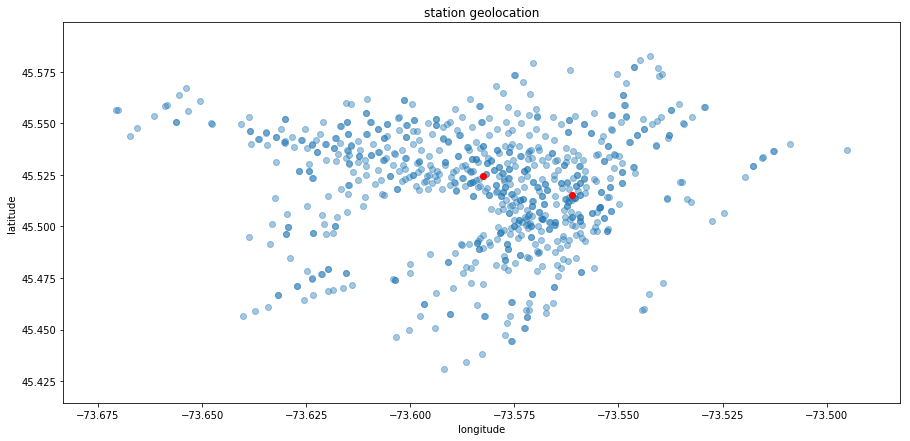

In [6]:
# from station 6184 to station 6015
selected_stations = stations[stations['code'].isin([6184, 6015])]

plt.figure(figsize=(15,7))
plt.scatter(x=stations["longitude"], y=stations["latitude"], alpha=0.4)
plt.scatter(x=selected_stations["longitude"], y=selected_stations["latitude"], c='red')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('station geolocation')
plt.show()

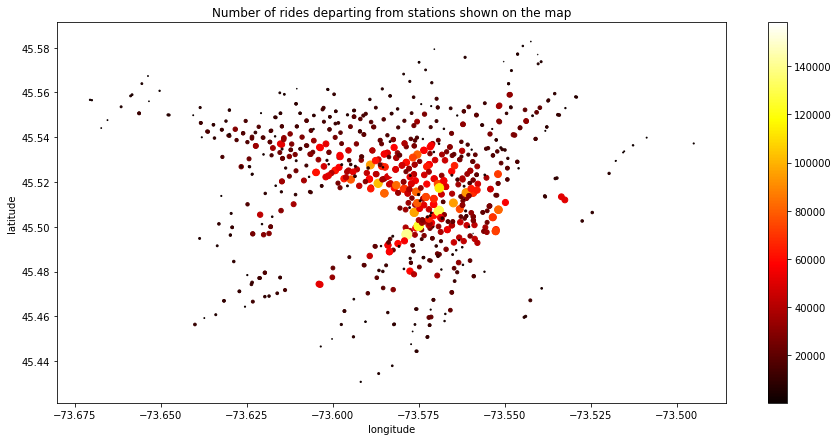

In [7]:
rides_start = rides.groupby(['start_station_code'])[['start_date']].count().reset_index()
rides_start_geo = rides_start.merge(stations, left_on='start_station_code', right_on='code', how='inner')

plt.figure(figsize=(15,7))
plt.scatter(x=rides_start_geo['longitude'], y=rides_start_geo['latitude'], 
            s=rides_start_geo['start_date']/1500, c=rides_start_geo['start_date'], cmap='hot')
plt.colorbar()
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('Number of rides departing from stations shown on the map')
plt.show()

# 2) simple and quick model focusing on time-based predictors 

## 2.1) prediction based on station pair 6184 --> 6015 data only


Note that it is possible to pass the winter months as holidays to prophet, but I haven't seen that making a notable difference.

In [8]:
rides_6184_to_6015 = rides_perday.loc[(rides_perday['start_station_code']==6184) & (rides_perday['end_station_code']==6015)]
rides_6184_to_6015.head()

date  start_station_code  end_station_code  rides_perlink_count  \
1123 2014-04-15                6184              6015                 2030   
3336 2014-04-16                6184              6015                 2030   
5549 2014-04-17                6184              6015                 2030   
7762 2014-04-18                6184              6015                 2030   
9975 2014-04-19                6184              6015                 2030   

     start_date_daytrunc  rides_perday  median_duration_sec_perday  
1123          2014-04-15           1.0                       517.0  
3336          2014-04-16           3.0                       580.0  
5549          2014-04-17           3.0                       412.0  
7762          2014-04-18           2.0                      1642.0  
9975          2014-04-19           1.0                       461.0

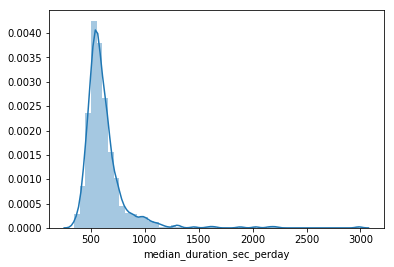

In [9]:
# a priori, this is pretty impressive for the median ride time per day to vary that much, but the median is over so few people...
# it may also be the reflection that some bikes are never returned or used to tour the city, different physical conditions, weather conditions etc
sns.distplot(rides_6184_to_6015.dropna()['median_duration_sec_perday'])

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



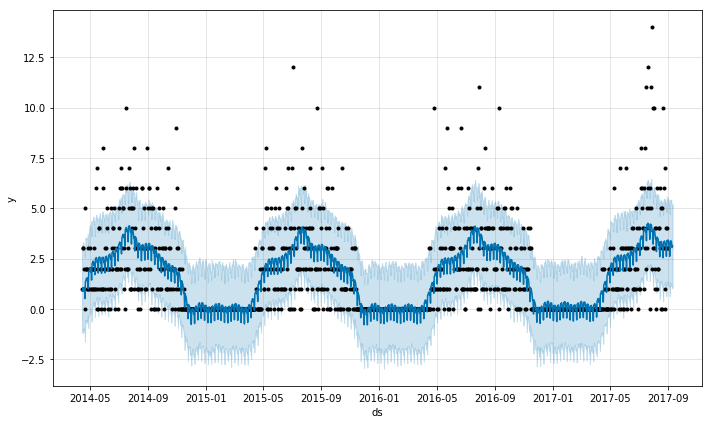

In [10]:
rides_6184_to_6015_prophet = pd.DataFrame({'ds':rides_6184_to_6015['date'].values, 
                                            'y':rides_6184_to_6015['rides_perday'].values})
m = Prophet()
m.fit(rides_6184_to_6015_prophet)
future = m.make_future_dataframe(periods=10)
forecast = m.predict(future)
fig1 = m.plot(forecast)

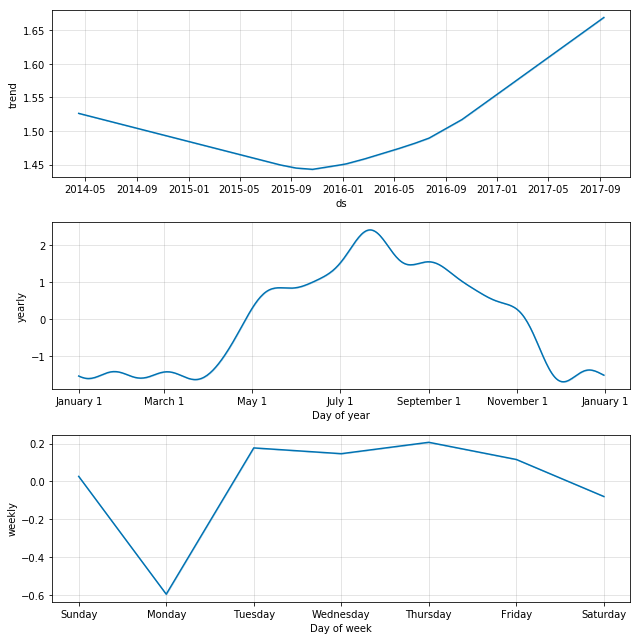

In [11]:
fig2 = m.plot_components(forecast)

- Overall trend looks weird: winter months may not be fully captured in the monthly seasonality. 
- Monthly seasonality makes sense: more rides in summer
- What's going on on Mondays?
 - perhaps check if that's only between those stations?
 - is it a museum or establishment being closed every Monday? or an event or road closure?
 - instructions clearly ask not to look for extra information

In [12]:
df_cv = cross_validation(m, initial='900 days', horizon = '10 days', period='5 days')
df_p = performance_metrics(df_cv, rolling_window=1, metrics=['rmse', 'mse'])
df_p

INFO:fbprophet.diagnostics:Making 65 forecasts with cutoffs between 2016-10-05 00:00:00 and 2017-08-21 00:00:00
/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



horizon      rmse       mse
649 10 days  1.745851  3.047995

In [13]:
requested_forecast = forecast[forecast['ds'].between(pd.to_datetime('2017-09-04'), pd.to_datetime('2017-09-10'))].set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']]
requested_forecast

yhat  yhat_lower  yhat_upper
ds                                          
2017-09-04  2.609275    0.626658    4.721298
2017-09-05  3.369529    1.308933    5.414675
2017-09-06  3.324990    1.261442    5.381927
2017-09-07  3.368137    1.112534    5.432806
2017-09-08  3.258106    1.158257    5.229954
2017-09-09  3.041101    1.018222    5.046339
2017-09-10  3.123190    1.050118    5.190121

Explore interactively variations between prediction and actual

In [14]:
combined_6184_to_6015 = pd.merge(rides_6184_to_6015_prophet, forecast, on='ds')
combined_6184_to_6015.head()

iplot(combined_6184_to_6015.set_index('ds')[['y', 'yhat', 'yhat_lower', 'yhat_upper']].iplot(asFigure=True,
       kind='scatter',xTitle='ds',yTitle='y',title='comparison between historical data and forecast', color=['blue', 'grey', 'black', 'black'], dash = ['solid', 'dashdot' , 'dash', 'dash']))

## 2.2) get a feel for trends overall in the network (incl. intraday), and predict 6184 to 6015 as if it was a scaled down version of the entire network

Exceptionnally here we won't force 0 values where data is missing (very little is missing when aggregated over the entire network, and prophet doesn't deal with this too badly). Just keep in mind that in the following trends, you should expect night rides and winter rides to be closer to 0.

In [15]:
   def winter_holidays(year):
    d1 = date(year,12,1)
    d2 = date(year+1,3,31)

    # this will give a list containing all of the dates
    return pd.to_datetime([d1 + timedelta(days=x) for x in range((d2-d1).days + 1)])


df_winter = pd.DataFrame({'ds':np.concatenate([winter_holidays(year) for year in np.arange(2014,2017)])})
df_winter['y'] = 0
df_winter.head()

ds  y
0 2014-12-01  0
1 2014-12-02  0
2 2014-12-03  0
3 2014-12-04  0
4 2014-12-05  0

/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



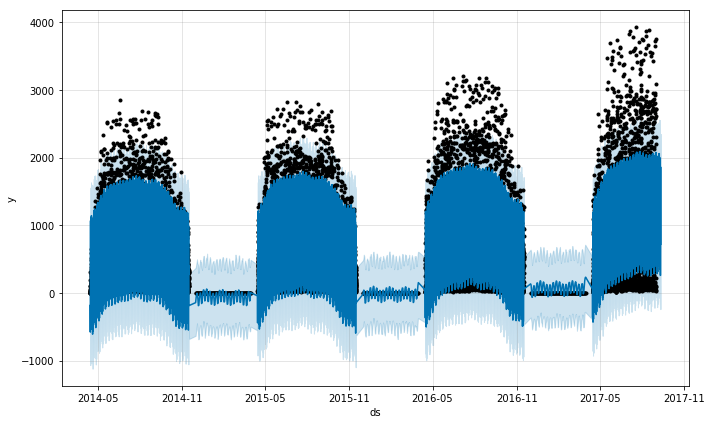

In [16]:
rides['start_date_hourtrunc'] = rides['start_date'].dt.floor('h')
rides_binned = rides.groupby('start_date_hourtrunc')[['start_date']].count()
rides_prophet = pd.concat([ pd.DataFrame({'ds':rides_binned.index, 'y':rides_binned['start_date'].values}),
                           df_winter], ignore_index=True)

holidays = pd.DataFrame({
  'holiday': 'winter',
  'ds': df_winter['ds'].values
})

m = Prophet(holidays=holidays)
m.fit(rides_prophet)
future = m.make_future_dataframe(periods=10*24, freq='H')
forecast = m.predict(future)
fig1 = m.plot(forecast)

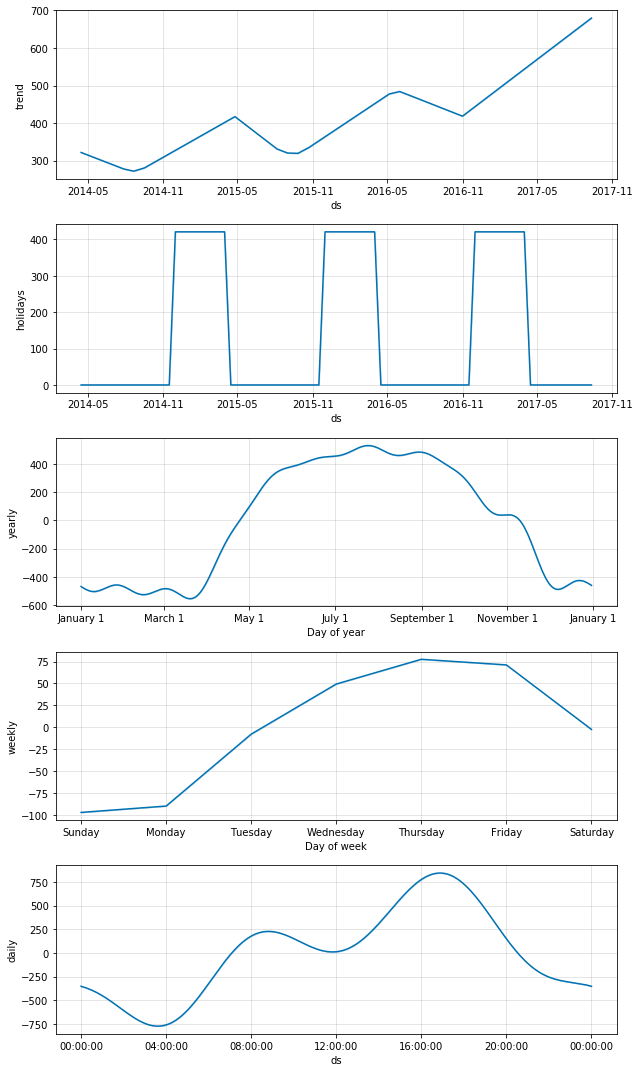

In [17]:
fig2 = m.plot_components(forecast)

In [18]:
scaling = rides_6184_to_6015_prophet[rides_6184_to_6015_prophet['ds']>='2017-08-01'].sum() / rides_prophet[rides_prophet['ds']>='2017-08-01'].sum()
scaling = scaling.values[0]
scaling

0.00012683651122794034

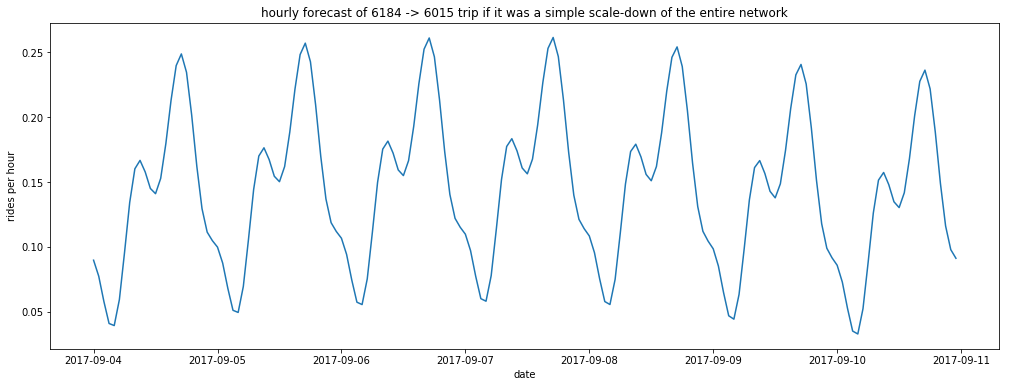

In [19]:
hourly_forecast = forecast[forecast['ds'].between(pd.to_datetime('2017-09-04 00:00:00'), pd.to_datetime('2017-09-10 23:59:59'))].set_index('ds')[['yhat']] * scaling
plt.figure(figsize=(17,6))
plt.plot(hourly_forecast)
plt.xlabel('date'); plt.ylabel('rides per hour'); plt.title('hourly forecast of 6184 -> 6015 trip if it was a simple scale-down of the entire network')
plt.show()

# 3) a rough attempt to capture more network effects and aggregate signal over entity clusters


## 3.1) clustering

**let's group station trips that have a correlated demand**

Many ways to measure proximity between stations, e.g. spatial or time distance, number of rides on the link, and demand correlation. Here we chose demand correlation semi-arbitrarily (makes sense + time limits, but more clusters could be learned).

We could play with clustering techniques that shift or compress timelines (such as fastdtw) if we thought there'd be such information delay in the network, but given the limited time I chose to keep things simple.

Below the number of cluster was chosen pretty arbitrarily, based on the number of items and the clusters I could visually see on the correlation matrices. However, given more time I'd look at cluster coherence and use something like an 'elbow technique'. With even more time, clusters could be tuned as hyperparameters to maximise the algorithms' predictions.

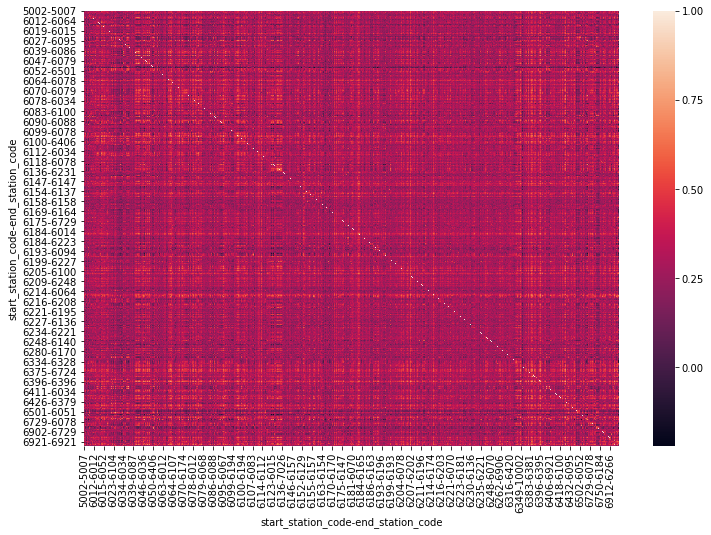

In [20]:
# ----------- work on start and end station pairs ('link') -----------
rides_perday_link_pivot = rides_perday.pivot_table(values='rides_perday', index=['start_station_code', 'end_station_code'], columns='date')

plt.figure(figsize=(12,8))
sns.heatmap(rides_perday_link_pivot.transpose().corr())

In [21]:
kmeans_link = KMeans(n_clusters=10, random_state=0).fit_predict(rides_perday_link_pivot)
df_link_clusters = rides_perday_link_pivot.reset_index()[['start_station_code','end_station_code']].assign(link_cluster = kmeans_link)
df_link_clusters.head()

date  start_station_code  end_station_code  link_cluster
0                   5002              5007             3
1                   5004              5007             3
2                   5005              5007             3
3                   5006              5007             3
4                   5007              5002             3

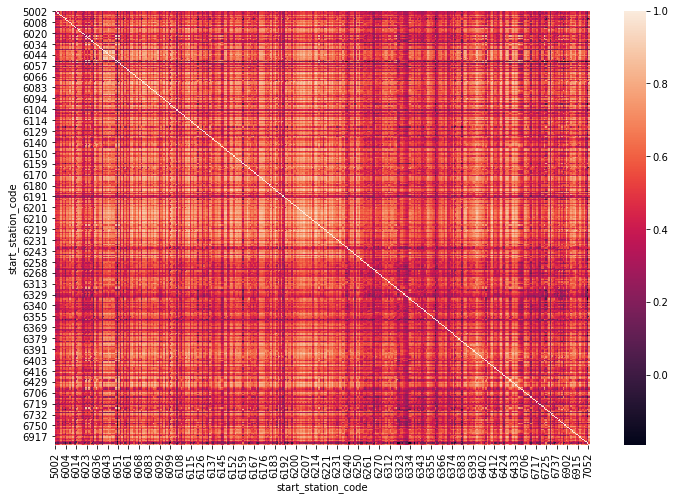

In [22]:
# ----------- work on start stations -----------
rides_perday_startstation = rides_perday.groupby(['start_station_code', 'date'])[['rides_perday']].sum()
rides_perday_startstation.reset_index(inplace=True)

rides_perday_startstation_pivot = rides_perday_startstation.pivot_table(values='rides_perday', index='start_station_code', columns='date')

plt.figure(figsize=(12,8))
sns.heatmap(rides_perday_startstation_pivot.transpose().corr())

In [23]:
kmeans_startstation = KMeans(n_clusters=10, random_state=0).fit_predict(rides_perday_startstation_pivot)
df_startstation_clusters = rides_perday_startstation_pivot.reset_index()[['start_station_code']].assign(startstation_cluster = kmeans_startstation)
df_startstation_clusters.head()

date  start_station_code  startstation_cluster
0                   5002                     5
1                   5004                     5
2                   5005                     5
3                   5006                     5
4                   5007                     5

## 3.2) feature engineering

In [24]:
def date_based_features(rides_perday):
       
    # ----- date based features -----
    rides_perday['year'] = rides_perday['date'].apply(lambda x: x.year)
    rides_perday['month'] = rides_perday['date'].apply(lambda x: x.month)
    rides_perday['week'] = rides_perday['date'].apply(lambda x: x.week)
    rides_perday['day_of_month'] = rides_perday['date'].apply(lambda x: x.day)
    rides_perday['day_of_week'] = rides_perday['date'].apply(lambda x: x.weekday())
    rides_perday['days_since_beginningdataset'] = rides_perday['date'].apply(lambda x: (x- pd.to_datetime('2014-04-15')).days)
    
    # average data over the week
    rides_perday_weekmean = rides_perday.groupby(['week', 'start_station_code', 'end_station_code'])[['rides_perday']].agg({'rides_perday':{'rides_perday_weekmean':'mean', 'rides_perday_weekmedian':'median'}})
    rides_perday = rides_perday.merge(rides_perday_weekmean, on=['week', 'start_station_code', 'end_station_code'])
    
    
    return rides_perday

def rides_relativeto_total_startandend_stations_traffic(rides_perday):
     
    # ---------- relative number of rides to total start and end station traffic ----------
    # start_station rides each week + day ride as a fraction of that
    start_station_importance_perweek = rides_perday.groupby(['start_station_code', 'week'])[['rides_perday']].agg({'rides_perday':{'meanrides_startstation_thisweek':'mean', 'medianrides_startstation_thisweek':'median'}})
    start_station_importance_perweek.reset_index(inplace=True)
    rides_perday = rides_perday.merge(start_station_importance_perweek, on=['start_station_code', 'week'], how='inner')
    rides_perday['rides_ratio_startstation'] = rides_perday['rides_perday'] / (rides_perday['meanrides_startstation_thisweek'] + 0.01)

    # end_station rides each week + day ride as a fraction of that
    end_station_importance_perweek = rides_perday.groupby(['end_station_code', 'week'])[['rides_perday']].agg({'rides_perday':{'meanrides_endstation_thisweek':'mean', 'medianrides_endstation_thisweek':'median'}})
    end_station_importance_perweek.reset_index(inplace=True)
    rides_perday = rides_perday.merge(end_station_importance_perweek, on=['end_station_code', 'week'], how='inner')
    rides_perday['rides_ratio_endstation'] = rides_perday['rides_perday'] / (rides_perday['meanrides_endstation_thisweek'] + 0.01)

    # link rides each week + day ride as a fraction of that
    link_importance_perweek = rides_perday.groupby(['start_station_code', 'end_station_code', 'week'])[['rides_perday']].agg({'rides_perday':{'meanrides_link_thisweek':'mean', 'medianrides_link_thisweek':'median'}})
    link_importance_perweek.reset_index(inplace=True)
    rides_perday = rides_perday.merge(link_importance_perweek, on=['start_station_code', 'end_station_code', 'week'], how='inner')
    rides_perday['rides_ratio_link'] = rides_perday['rides_perday'] / (rides_perday['meanrides_link_thisweek'] + 0.01)
    rides_perday['rides_ratio_linkmedian'] = rides_perday['rides_perday'] / (rides_perday['medianrides_link_thisweek'] + 0.01)
    
    return rides_perday

def clusters_features(rides_perday):
    
    # ---------- clusters ----------
    # define clusters
    rides_perday = rides_perday.merge(df_link_clusters, on=['start_station_code', 'end_station_code'], how='inner')
    rides_perday = rides_perday.merge(df_startstation_clusters, on=['start_station_code'], how='inner')
    
    # ----- calculate rides statistics linked to each cluster
    # link cluster: daily predictions on the cluster, and on specific station by taking ratio over a week
    rides_perday_linkcluster = rides_perday.groupby(['date', 'link_cluster'])[['rides_perday']].agg({'rides_perday':{'rides_perday_linkcluster':'mean'}}).reset_index()
    rides_perday = rides_perday.merge(rides_perday_linkcluster, on=['date', 'link_cluster'], how='inner')
    
    rides_linkcluster_thisweek = rides_perday.groupby(['week', 'link_cluster'])[['rides_perday_linkcluster']].agg({'rides_perday_linkcluster':{'rides_perday_linkcluster_weeklymean':'mean', 'rides_perday_linkcluster_weeklymedian':'median'}}).reset_index()
    rides_perday = rides_perday.merge(rides_linkcluster_thisweek, on=['week', 'link_cluster'])
    
    rides_perday['rides_linkcluster_ratio_weekly'] = rides_perday['rides_perday_weekmean'] / (rides_perday['rides_perday_linkcluster_weeklymean'] + 0.01)
    rides_perday['rides_perday_linkcluster_adj'] = rides_perday['rides_linkcluster_ratio_weekly'] * rides_perday['rides_perday_linkcluster']
                      
    # start station cluster: daily predictions on the cluster, and on specific station by taking ratio over a week                                                                                                        
    rides_perday_startstationcluster = rides_perday.groupby(['date', 'startstation_cluster'])[['rides_perday']].agg({'rides_perday':{'rides_perday_startstationcluster':'mean', 'rides_perday_startstationcluster_median':'median'}}).reset_index()
    rides_perday = rides_perday.merge(rides_perday_startstationcluster, on=['date', 'startstation_cluster'], how='inner')
    
    rides_startcluster_thisweek = rides_perday.groupby(['week', 'startstation_cluster'])[['rides_perday_startstationcluster']].agg({'rides_perday_startstationcluster':{'rides_perday_startcluster_weeklymean':'mean', 'rides_perday_startcluster_weeklymedian':'median'}})
    rides_perday = rides_perday.merge(rides_startcluster_thisweek, on=['week', 'startstation_cluster'])
    
    rides_perday['rides_startcluster_ratio_weekly'] = rides_perday['rides_perday_weekmean'] / (rides_perday['rides_perday_startcluster_weeklymean'] + 0.01)
    rides_perday['rides_perday_startcluster_adj'] = rides_perday['rides_startcluster_ratio_weekly'] * rides_perday['rides_perday_startstationcluster']
                                                                                                                        
    return rides_perday 

def lags(rides_perday):
    
     # ----- order dataframe as we'll be using lag functions later -----
    rides_perday.sort_values(by=['start_station_code', 'end_station_code', 'date'], ascending=True, inplace=True)
    
    
    # ---------- pass past data ----------
    # use lag to get latest ride number
    rides_perday['rides_10daysago'] = rides_perday.groupby(['start_station_code', 'end_station_code'])['rides_perday'].shift(10)
    rides_perday['rides_11daysago'] = rides_perday.groupby(['start_station_code', 'end_station_code'])['rides_perday'].shift(11)
    rides_perday['rides_12daysago'] = rides_perday.groupby(['start_station_code', 'end_station_code'])['rides_perday'].shift(12)
    rides_perday['rides_13daysago'] = rides_perday.groupby(['start_station_code', 'end_station_code'])['rides_perday'].shift(13)
    rides_perday['rides_14daysago'] = rides_perday.groupby(['start_station_code', 'end_station_code'])['rides_perday'].shift(14)
    rides_perday['rides_15daysago'] = rides_perday.groupby(['start_station_code', 'end_station_code'])['rides_perday'].shift(15)

    # use lag to get latest time duration between stations, and relative number of rides
        # perhaps should I aggregate median duration over a week instead of taking only a day
    rides_perday['median_duration_10daysago'] = rides_perday.groupby(['start_station_code', 'end_station_code'])['median_duration_sec_perday'].shift(10)
    
    rides_perday['medianrides_startstation_week14daysago'] = rides_perday.groupby(['start_station_code', 'end_station_code'])['medianrides_startstation_thisweek'].shift(14)
    rides_perday['medianrides_endstation_week14daysago'] = rides_perday.groupby(['start_station_code', 'end_station_code'])['medianrides_endstation_thisweek'].shift(14)
    rides_perday['medianrides_link_week14daysago'] = rides_perday.groupby(['start_station_code', 'end_station_code'])['medianrides_link_thisweek'].shift(14)

    rides_perday['rides_ratio_startstation_14daysago'] = rides_perday.groupby(['start_station_code', 'end_station_code'])['rides_ratio_startstation'].shift(14)
    rides_perday['rides_ratio_endstation_14daysago'] = rides_perday.groupby(['start_station_code', 'end_station_code'])['rides_ratio_endstation'].shift(14)
    rides_perday['rides_ratio_link_14daysago'] = rides_perday.groupby(['start_station_code', 'end_station_code'])['rides_ratio_link'].shift(14)
    rides_perday['rides_ratio_linkmedian_14daysago'] = rides_perday.groupby(['start_station_code', 'end_station_code'])['rides_ratio_linkmedian'].shift(14)

    # calculate change for our latest data
    rides_perday['rides_10daysago_diff1'] = rides_perday.groupby(['start_station_code', 'end_station_code'])['rides_10daysago'].diff(periods=1)
    rides_perday['rides_10daysago_diff7'] = rides_perday.groupby(['start_station_code', 'end_station_code'])['rides_10daysago'].diff(periods=7)
    rides_perday['rides_11daysago_diff1'] = rides_perday.groupby(['start_station_code', 'end_station_code'])['rides_11daysago'].diff(periods=1)
    rides_perday['rides_11daysago_diff7'] = rides_perday.groupby(['start_station_code', 'end_station_code'])['rides_11daysago'].diff(periods=7)
    
    # --------------- cluster data ---------------
    # cluster rides per day
    rides_perday['rides_link_cluster_14daysago'] = rides_perday.groupby(['start_station_code', 'end_station_code'])['rides_perday_linkcluster'].shift(14)
    rides_perday['rides_start_cluster_14daysago'] = rides_perday.groupby(['start_station_code', 'end_station_code'])['rides_perday_startstationcluster'].shift(14)
    
    # smoothed prediction of station data, from cluster
    rides_perday['rides_perday_linkcluster_adj_14daysago'] = rides_perday.groupby(['start_station_code', 'end_station_code'])['rides_perday_linkcluster_adj'].shift(14)
    rides_perday['rides_perday_startcluster_adj_14daysago'] = rides_perday.groupby(['start_station_code', 'end_station_code'])['rides_perday_startcluster_adj'].shift(14)
    
    # change on cluster predictions
    rides_perday['rides_perday_linkcluster_adj_14daysago_diff1'] = rides_perday.groupby(['start_station_code', 'end_station_code'])['rides_perday_linkcluster_adj_14daysago'].diff(periods=1)
    rides_perday['rides_perday_linkcluster_adj_14daysago_diff7'] = rides_perday.groupby(['start_station_code', 'end_station_code'])['rides_perday_linkcluster_adj_14daysago'].diff(periods=7)
    
    rides_perday['rides_perday_startcluster_adj_14daysago_diff1'] = rides_perday.groupby(['start_station_code', 'end_station_code'])['rides_perday_startcluster_adj_14daysago'].diff(periods=1)
    rides_perday['rides_perday_startcluster_adj_14daysago_diff7'] = rides_perday.groupby(['start_station_code', 'end_station_code'])['rides_perday_startcluster_adj_14daysago'].diff(periods=7)
    
    return rides_perday

In [25]:
# --------------- TO DO: go through my features, and check:
# - that I haven't forgotten to pass major ones through lag
# - that I haven't included too many features that are colinear

In [26]:
def feature_engineering(rides_perday):
    '''
    basic requirements for each row on this table:
    - date
    - start_station_code
    - end_station_code
    
    there should be past data also (at least 20 days, but way more in practice)
    
    '''
    
    return lags(clusters_features(rides_relativeto_total_startandend_stations_traffic(date_based_features(rides_perday))))


In [27]:
# to allow feature engineering, I need to process my forecasted dates with the historical values
# GENERATE DATES TO FORECAST HERE and add to dataframe at the end
rides_perday = feature_engineering(rides_perday)
rides_perday.head(20)

/anaconda3/lib/python3.6/site-packages/pandas/core/groupby/groupby.py:4658: FutureWarning:

using a dict with renaming is deprecated and will be removed in a future version



date  start_station_code  end_station_code  rides_perlink_count  \
0      2014-04-15                5002              5007                  778   
343    2014-04-16                5002              5007                  778   
686    2014-04-17                5002              5007                  778   
1029   2014-04-18                5002              5007                  778   
1372   2014-04-19                5002              5007                  778   
1715   2014-04-20                5002              5007                  778   
59751  2014-04-21                5002              5007                  778   
60094  2014-04-22                5002              5007                  778   
60437  2014-04-23                5002              5007                  778   
60780  2014-04-24                5002              5007                  778   
61123  2014-04-25                5002              5007                  778   
61466  2014-04-26                5002              5007                  778   
61809  2014-04-27                5002              5007                  778   
121715 2014-04-28                5002              5007                  778   
122058 2014-04-29                5002              5007                  778   
122401 2014-04-30                5002              5007                  778   
122744 2014-05-01                5002              5007                  778   
123087 2014-05-02                5002              5007                  778   
123430 2014-05-03                5002              5007                  778   
123773 2014-05-04                5002              5007                  778   

       start_date_daytrunc  rides_perday  median_duration_sec_perday  year  \
0                      NaT           0.0                         NaN  2014   
343             2014-04-16           1.0                       348.0  2014   
686                    NaT           0.0                         NaN  2014   
1029            2014-04-18           1.0                       322.0  2014   
1372                   NaT           0.0                         NaN  2014   
1715                   NaT           0.0                         NaN  2014   
59751                  NaT           0.0                         NaN  2014   
60094                  NaT           0.0                         NaN  2014   
60437           2014-04-23           2.0                       278.0  2014   
60780           2014-04-24           1.0                       370.0  2014   
61123           2014-04-25           1.0                       321.0  2014   
61466                  NaT           0.0                         NaN  2014   
61809                  NaT           0.0                         NaN  2014   
121715                 NaT           0.0                         NaN  2014   
122058                 NaT           0.0                         NaN  2014   
122401          2014-04-30           1.0                       297.0  2014   
122744                 NaT           0.0                         NaN  2014   
123087                 NaT           0.0                         NaN  2014   
123430          2014-05-03           1.0                       275.0  2014   
123773                 NaT           0.0                         NaN  2014   

        month  week                      ...                        \
0           4    16                      ...                         
343         4    16                      ...                         
686         4    16                      ...                         
1029        4    16                      ...                         
1372        4    16                      ...                         
1715        4    16                      ...                         
59751       4    17                      ...                         
60094       4    17                      ...                         
60437       4    17                      ...                   

## 3.3) filter features and format for model

In [28]:
rides_perday_dropped = rides_perday

# TO DO: all these variables need tidying up

# drop variables that are probably redundant
rides_perday_dropped.drop(['day_of_month'
                    
                         ], axis=1, inplace=True)

# drop variables that won't be accessible for predictions
rides_perday_dropped.drop(['date', 'start_date_daytrunc', 'rides_perlink_count', 'median_duration_sec_perday',
   'rides_perday_weekmean', 'rides_perday_weekmedian', 'meanrides_startstation_thisweek',
   'medianrides_startstation_thisweek', 'rides_ratio_startstation', 'meanrides_endstation_thisweek',
   'medianrides_endstation_thisweek', 'rides_ratio_endstation', 'meanrides_link_thisweek',
   'medianrides_link_thisweek', 'rides_ratio_link', 'rides_ratio_linkmedian', 
   'rides_perday_linkcluster', 'rides_perday_linkcluster_weeklymean', 'rides_perday_linkcluster_weeklymedian',
   'rides_linkcluster_ratio_weekly', 'rides_perday_linkcluster_adj', 'rides_perday_startstationcluster',
   'rides_perday_startstationcluster_median', 'rides_perday_startcluster_weeklymean', 
   'rides_perday_startcluster_weeklymedian', 'rides_startcluster_ratio_weekly', 'rides_perday_startcluster_adj'
                    
                         ], axis=1, inplace=True)

# transform a few categorical variables into dummies
# to avoid overfitting, we'll limit it to the minimum
rides_perday_dropped = pd.get_dummies(rides_perday_dropped,
                  columns=['month', 'day_of_week', 'link_cluster', 'startstation_cluster'
                       #    ,'start_station_code', 'end_station_code'
                          ], drop_first=True)
# dummies for the start and end station codes would be a lot. By giving data over the previous few weeks, 
# this should allow to pick up some specificities about each link, while trying to generalize the results

rides_perday_dropped.replace([np.inf, -np.inf], np.nan)
rides_perday_dropped.dropna(inplace=True, how='any')


In [29]:
print(pd.to_datetime('2014-04-15') + timedelta(days=1115))
print(rides_perday_dropped['days_since_beginningdataset'].max())
print(rides_perday_dropped['days_since_beginningdataset'].min())

2017-05-04 00:00:00
1234
21


# metrics and cross validation

In [30]:
# RMSE applied to the log of the target and the prediction output.
# It works as an approximation to the percentage error between our predictions and the target, which is a nice way to understand the errors our model is making.

from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error

def rmsle(ytrue, ypred):
    return np.sqrt(mean_squared_log_error(ytrue, ypred))

def rmse(ytrue, ypred):
    return np.sqrt(mean_squared_error(ytrue, ypred))

In [41]:
# forecast is 4-10 days in advance for this exercise. 
# We'll give the model all the data to a certain point, and predict the next 10 days
# To test our script we'll test this kind of predictions multiple times, and average the results out

# 1200 to 1234 will be reserved for final test
rides_perday_test = rides_perday_dropped.loc[rides_perday_dropped['days_since_beginningdataset']>1200]

rides_perday_crossval = rides_perday_dropped.loc[rides_perday_dropped['days_since_beginningdataset']<=1200]

# we're left with 0 to 1200 days for cross validation
# we'll dedicate at least 1115 days to training (a big part is winter closure)
# 900-1115 days will be for cross validation


# to control computational power, we'll run the validation every 42 days (5 iterations)

def timeseries_crossvalidation(model, number_test=5, end_purelearning=1115, end_crossvalidation_set = 1200):
    period = (end_crossvalidation_set-end_purelearning) // number_test
    
    mean_error_rmsle = []
    mean_error_rmse = []
    for cutoff_day in range(end_purelearning, end_crossvalidation_set, period):
        
        #print(cutoff_day)
        #print(cutoff_day - 9)
        
        train = rides_perday_crossval[rides_perday_crossval['days_since_beginningdataset'] < cutoff_day-9]
        val = rides_perday_crossval[rides_perday_crossval['days_since_beginningdataset'].between(cutoff_day-9, cutoff_day)]
        
        #print('train', train)
        #print()
        #print('val', val)
        
        xtr, xts = train.drop('rides_perday', axis=1), val.drop('rides_perday', axis=1)
            
        ytr, yts = train['rides_perday'].values, val['rides_perday'].values
        
        model.fit(xtr, ytr)
        
        p = model.predict(xts)
        error_rmsle = rmsle(yts, pd.DataFrame({'p':p}).clip_lower(0).values)
        error_rmse = rmse(yts, p)
        
        print('Cutoffday %d - RMSLE %.5f, RMSE %.5f' % (cutoff_day, error_rmsle, error_rmse))
        mean_error_rmsle.append(error_rmsle)
        mean_error_rmse.append(error_rmse)
        
    print('Mean error over crossvalidation set - - RMSLE %.5f, RMSE %.5f' % (np.mean(mean_error_rmsle), np.mean(mean_error_rmse))) 

In [32]:
rides_perday_dropped.shape[0] / rides_perday_dropped.shape[1] 

16212.432835820895

In [33]:
# baseline
# a simple way to predict naively what will happen is to look at the past datapoint on the same day of the week
# p = val['rides_14daysago'].values

# 3.5) modelling

In [34]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.neighbors import KNeighborsRegressor

In [42]:
random_state = 2

models = [
    LinearRegression(n_jobs=-1)
    , RandomForestRegressor(n_jobs=-1, random_state=random_state, n_estimators=20)
#    , AdaBoostRegressor(random_state=random_state)
#    , GradientBoostingRegressor(random_state=random_state)
#    , MLPRegressor(random_state=random_state)
#    , SGDRegressor(random_state=random_state)
#    , BaggingRegressor(n_jobs=-1, random_state=random_state)
    , KNeighborsRegressor(n_jobs=-1)
    
]

model_names = [
    "LinearRegression"
    , "RandomForestRegressor"
#    , "AdaBoostRegressor"
#    , "GradientBoostingRegressor"
#    , "MLPRegressor"
#    , 'SGDRegressor'
#    , 'BaggingRegressor'
    , 'KNeighborsRegressor'
]

i=0
for model in models:
    print(model_names[i])
    timeseries_crossvalidation(model, number_test=3)
    print('')
    i=i+1

LinearRegression
Cutoffday 1115 - RMSLE 0.60859, RMSE 1.79789
Cutoffday 1143 - RMSLE 0.63920, RMSE 2.95632
Cutoffday 1171 - RMSLE 0.61691, RMSE 2.33480
Cutoffday 1199 - RMSLE 0.64290, RMSE 2.44665
Mean error over crossvalidation set - - RMSLE 0.62690, RMSE 2.38391

RandomForestRegressor
Cutoffday 1115 - RMSLE 0.79624, RMSE 2.35689
Cutoffday 1143 - RMSLE 0.65152, RMSE 2.89092
Cutoffday 1171 - RMSLE 0.69632, RMSE 2.46202
Cutoffday 1199 - RMSLE 0.67787, RMSE 2.51605
Mean error over crossvalidation set - - RMSLE 0.70549, RMSE 2.55647

KNeighborsRegressor
Cutoffday 1115 - RMSLE 0.98497, RMSE 2.62676
Cutoffday 1143 - RMSLE 0.71826, RMSE 3.27916
Cutoffday 1171 - RMSLE 0.70139, RMSE 2.75291
Cutoffday 1199 - RMSLE 0.71858, RMSE 2.88858
Mean error over crossvalidation set - - RMSLE 0.78080, RMSE 2.88685



Feature ranking:
1. feature 23 rides_link_cluster_14daysago (0.186965)
2. feature 25 rides_perday_linkcluster_adj_14daysago (0.107598)
3. feature 28 rides_perday_linkcluster_adj_14daysago_diff7 (0.042132)
4. feature 3 week (0.040251)
5. feature 11 median_duration_10daysago (0.035349)
6. feature 27 rides_perday_linkcluster_adj_14daysago_diff1 (0.034150)
7. feature 26 rides_perday_startcluster_adj_14daysago (0.032744)
8. feature 30 rides_perday_startcluster_adj_14daysago_diff7 (0.031399)
9. feature 29 rides_perday_startcluster_adj_14daysago_diff1 (0.031226)
10. feature 4 days_since_beginningdataset (0.029885)
11. feature 24 rides_start_cluster_14daysago (0.029296)
12. feature 1 end_station_code (0.025293)
13. feature 0 start_station_code (0.025011)
14. feature 9 rides_14daysago (0.024847)
15. feature 8 rides_13daysago (0.022744)
16. feature 16 rides_ratio_endstation_14daysago (0.022317)
17. feature 10 rides_15daysago (0.021778)
18. feature 15 rides_ratio_startstation_14daysago (0.021313)

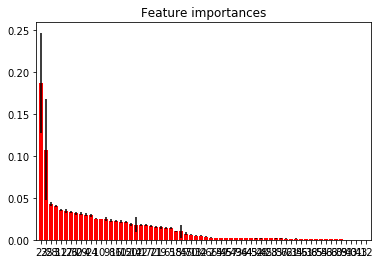

In [43]:
importances = models[1].feature_importances_
std = np.std([tree.feature_importances_ for tree in models[1].estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking and contribution
print("Feature ranking:")

for f in range(rides_perday_crossval.drop('rides_perday', axis=1).shape[1]):
    print("%d. feature %d %s (%f)" % (f + 1, indices[f],rides_perday_crossval.drop('rides_perday', axis=1).columns.tolist()[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(rides_perday_crossval.drop('rides_perday', axis=1).shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(rides_perday_crossval.drop('rides_perday', axis=1).shape[1]), indices)
plt.xlim([-1, rides_perday_crossval.drop('rides_perday', axis=1).shape[1]])
plt.show()

For a random forrest, the feature importance represents the average of reduction in impurity index over all trees, when a particular feature is used at split point. This is normalized so it sums to 1.

As many of our features are related, the choice of the first feature to split the tree among related features will be somewhat random, and so will the feature importance.

In [44]:
#LinearRegression_coefficients = pd.DataFrame({"Feature":rides_perday_crossval.drop('rides_perday', axis=1).columns,"Coefficients":np.transpose(models[0].coef_)})
#LinearRegression_coefficients.sort_values(by='Coefficients', ascending=False)

## hyperparameter tuning

gridsearchCV

## learning curves

diagnose under or overfitting

# ensemble voting

aggregate predictions from very different models